# Online Retail 2 Data Set

Çalışmanın amacı RFM ile müşterilerin ne kadar süre önce alışveriş yaptıkları, her bir müşteriye ait fatura adetleri ve herbir müşterinin toplam harcamasını hesaplayıp, bu özelliklere göre kmeans denetimsiz öğrenme algoritmasını kullanarak müşterileri gruplandırmaktır. Veri ön işleme ve keşifci veri analizi adımlarından sonra RFM hesaplanıp, kmeans modeli oluşturulacaktır.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv("online_retail_II.csv")
veri=data.copy()
veri.head()

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
veri=veri.drop(columns="Unnamed: 0")
veri.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


* InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
* StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
* Description: Product (item) name. Nominal.
* Quantity: The quantities of each product (item) per transaction. Numeric.
* InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
* UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
* CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
* Country: Country name. Nominal. The name of the country where a customer resides.


In [4]:
veri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
veri.isnull().sum()/len(veri)

Invoice        0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
Price          0.000000
Customer ID    0.249266
Country        0.000000
dtype: float64

In [6]:
veri=veri.dropna()
veri.isnull().sum()/len(veri)

Invoice        0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
Price          0.0
Customer ID    0.0
Country        0.0
dtype: float64

In [7]:
veri[veri.duplicated()].shape

(5225, 8)

In [8]:
veri=veri.drop_duplicates(keep="first") # tekrarlanan verileri silme:
veri.shape

(401605, 8)

In [9]:
veri.reset_index(drop=True, inplace=True)

In [10]:
veri.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

# Değişken isimlerini Türkçe Yapmak:

In [11]:
veri.rename(columns={"Invoice":"Fatura No","StockCode":"Stok Kodu","Description":"Ürün Adı",
"Quantity":"Adet","InvoiceDate":"Fatura Tarihi","Price":"Birim Fiyat","Customer ID":"Müşteri ID","Country":"Ülke"}, inplace=True)

print(veri.head())

  Fatura No Stok Kodu                             Ürün Adı  Adet  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER     6   
1    536365     71053                  WHITE METAL LANTERN     6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER     8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE     6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.     6   

         Fatura Tarihi  Birim Fiyat  Müşteri ID            Ülke  
0  2010-12-01 08:26:00         2.55     17850.0  United Kingdom  
1  2010-12-01 08:26:00         3.39     17850.0  United Kingdom  
2  2010-12-01 08:26:00         2.75     17850.0  United Kingdom  
3  2010-12-01 08:26:00         3.39     17850.0  United Kingdom  
4  2010-12-01 08:26:00         3.39     17850.0  United Kingdom  


# Veri Ön İşleme

In [12]:
# İptal faturalarını veri setinden çıkartalım:
veri = veri[~veri["Fatura No"].str.contains("C")]
# fatura tarihini tarih yapısına çevirme:
veri["Fatura Tarihi"]=pd.to_datetime(veri["Fatura Tarihi"])

In [13]:
# Faturanın 6 haneli sayı olmalı kontrol edelim:
veri[(veri["Fatura No"].str.len()!=6) | (~veri["Fatura No"].str.isdigit())]

,Fatura No,Stok Kodu,Ürün Adı,Adet,Fatura Tarihi,Birim Fiyat,Müşteri ID,Ülke


In [14]:
# stok kodu 5 haneli olmalı:
veri[(veri["Stok Kodu"].str.len()!=5) | (~veri["Stok Kodu"].str.isdigit())]

,Fatura No,Stok Kodu,Ürün Adı,Adet,Fatura Tarihi,Birim Fiyat,Müşteri ID,Ülke
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France
...,...,...,...,...,...,...,...,...
401504,581579,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2011-12-09 12:19:00,1.79,17581.0,United Kingdom
401536,581580,84993A,75 GREEN PETIT FOUR CASES,2,2011-12-09 12:20:00,0.42,12748.0,United Kingdom
401542,581580,85049A,TRADITIONAL CHRISTMAS RIBBONS,1,2011-12-09 12:20:00,1.25,12748.0,United Kingdom
401551,581580,85049E,SCANDINAVIAN REDS RIBBONS,2,2011-12-09 12:20:00,1.25,12748.0,United Kingdom


In [15]:
len(veri[(veri["Stok Kodu"].str.len()!=5) | (~veri["Stok Kodu"].str.isdigit())])/len(veri)

0.08765242543916604

In [16]:
# Birim fiyatı 0 olanları çıkarma:
veri=veri[(veri["Birim Fiyat"]!=0) & (veri["Birim Fiyat"]>0)]
veri.head()

,Fatura No,Stok Kodu,Ürün Adı,Adet,Fatura Tarihi,Birim Fiyat,Müşteri ID,Ülke
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [17]:
len(veri[(veri["Stok Kodu"].str.len()!=5) | (~veri["Stok Kodu"].str.isdigit())])/len(veri)

0.08764098163196186

In [18]:
# Ürün Adı String olmalı:
veri[veri["Ürün Adı"].str.isdigit()]

,Fatura No,Stok Kodu,Ürün Adı,Adet,Fatura Tarihi,Birim Fiyat,Müşteri ID,Ülke


In [19]:
# Adetler 0 dan küçük olmamalı:
veri[veri["Adet"]<=0]

,Fatura No,Stok Kodu,Ürün Adı,Adet,Fatura Tarihi,Birim Fiyat,Müşteri ID,Ülke


In [20]:
# Yanlış Girilen Ülke Var mı?
print(veri["Ülke"].unique())

['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Finland' 'Austria' 'Greece' 'Singapore' 'Lebanon'
 'United Arab Emirates' 'Israel' 'Saudi Arabia' 'Czech Republic' 'Canada'
 'Unspecified' 'Brazil' 'USA' 'European Community' 'Bahrain' 'Malta' 'RSA']


In [21]:
print(veri["Ürün Adı"].unique())

['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' ... 'PINK CRYSTAL SKULL PHONE CHARM'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE']


In [22]:
# Toplam Tutar Ekleyelim:
veri["Toplam Tutar"]=veri["Birim Fiyat"]*veri["Adet"]
veri.head()

,Fatura No,Stok Kodu,Ürün Adı,Adet,Fatura Tarihi,Birim Fiyat,Müşteri ID,Ülke,Toplam Tutar
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [23]:
veri.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392693 entries, 0 to 401604
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Fatura No      392693 non-null  object        
 1   Stok Kodu      392693 non-null  object        
 2   Ürün Adı       392693 non-null  object        
 3   Adet           392693 non-null  int64         
 4   Fatura Tarihi  392693 non-null  datetime64[ns]
 5   Birim Fiyat    392693 non-null  float64       
 6   Müşteri ID     392693 non-null  float64       
 7   Ülke           392693 non-null  object        
 8   Toplam Tutar   392693 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.0+ MB


In [24]:
veri["Müşteri ID"]=veri["Müşteri ID"].astype("int64")

In [25]:
veri.info() # veri tipleri düzenlendi.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392693 entries, 0 to 401604
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Fatura No      392693 non-null  object        
 1   Stok Kodu      392693 non-null  object        
 2   Ürün Adı       392693 non-null  object        
 3   Adet           392693 non-null  int64         
 4   Fatura Tarihi  392693 non-null  datetime64[ns]
 5   Birim Fiyat    392693 non-null  float64       
 6   Müşteri ID     392693 non-null  int64         
 7   Ülke           392693 non-null  object        
 8   Toplam Tutar   392693 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.0+ MB


In [26]:
veri=veri.reset_index()
veri=veri.drop("index",axis=1)

In [27]:
veri.head()

,Fatura No,Stok Kodu,Ürün Adı,Adet,Fatura Tarihi,Birim Fiyat,Müşteri ID,Ülke,Toplam Tutar
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [28]:
len(data)

541910

In [29]:
len(veri)

392693

Kategori stütunu yaratmaya çalışalım. Ürün adı değişkeni incelendiğinde kategorilere ait isimler genelde sonda yer almaktadır.

In [30]:
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
nltk.download("wordnet")
lema=nltk.WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\okand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\okand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Kategorileri ortaya çıkarabilmek için ilk olarak ürün adı değişkenine doğal dil işleme yapılır:

In [31]:
temiz=[]

for i in range(len(veri)):
    duzenle=re.sub('[^a-zA-Z]'," ",veri["Ürün Adı"][i])
    duzenle=duzenle.lower()
    duzenle=duzenle.split()
    duzenle=[lema.lemmatize(kelime) for kelime in duzenle if not kelime in set(stopwords.words("english"))]
    duzenle=" ".join(duzenle)
    temiz.append(duzenle)

In [32]:
veri["Ürün Adı2"]=temiz
veri.head()

,Fatura No,Stok Kodu,Ürün Adı,Adet,Fatura Tarihi,Birim Fiyat,Müşteri ID,Ülke,Toplam Tutar,Ürün Adı2
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,white hanging heart light holder
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,white metal lantern
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,cream cupid heart coat hanger
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,knitted union flag hot water bottle
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,red woolly hottie white heart


In [33]:
kategori=[]

for i in range(0,len(veri)):
    duzenle=veri["Ürün Adı2"][i].split()
    duzenle=duzenle[-1]
    kategori.append(duzenle)

kategori[0:20]

['holder',
 'lantern',
 'hanger',
 'bottle',
 'heart',
 'box',
 'holder',
 'jack',
 'dot',
 'jar',
 'fashion',
 'fashion',
 'fashion',
 'ornament',
 'bedroom',
 'kitchen',
 'doll',
 'cosy',
 'teaspoon',
 'block']

In [34]:
veri["Kategori"]=kategori
veri.head()

,Fatura No,Stok Kodu,Ürün Adı,Adet,Fatura Tarihi,Birim Fiyat,Müşteri ID,Ülke,Toplam Tutar,Ürün Adı2,Kategori
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,white hanging heart light holder,holder
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,white metal lantern,lantern
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,cream cupid heart coat hanger,hanger
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,knitted union flag hot water bottle,bottle
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,red woolly hottie white heart,heart


In [35]:
veri.isnull().sum()

Fatura No        0
Stok Kodu        0
Ürün Adı         0
Adet             0
Fatura Tarihi    0
Birim Fiyat      0
Müşteri ID       0
Ülke             0
Toplam Tutar     0
Ürün Adı2        0
Kategori         0
dtype: int64

In [36]:
veri["Gün"]=veri["Fatura Tarihi"].dt.day
veri["Hafta"]=veri["Fatura Tarihi"].dt.week
veri["Ay"]=veri["Fatura Tarihi"].dt.month
veri["Yıl"]=veri["Fatura Tarihi"].dt.year
# Mevsimler:
veri["Mevsim"]=np.where(veri["Ay"].isin([3,4,5]),"İlkbahar",
                       np.where(veri["Ay"].isin([6,7,8]),"Yaz",
                               np.where(veri["Ay"].isin([9,10,11]),"Sonbahar",
                                       np.where(veri["Ay"].isin([12,1,2]),"Kış","None"))))

veri[["Fatura Tarihi","Gün","Hafta","Ay","Yıl","Mevsim"]]

C:\Users\okand\AppData\Local\Temp\ipykernel_15488\2506180762.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  veri["Hafta"]=veri["Fatura Tarihi"].dt.week


,Fatura Tarihi,Gün,Hafta,Ay,Yıl,Mevsim
0,2010-12-01 08:26:00,1,48,12,2010,Kış
1,2010-12-01 08:26:00,1,48,12,2010,Kış
2,2010-12-01 08:26:00,1,48,12,2010,Kış
3,2010-12-01 08:26:00,1,48,12,2010,Kış
4,2010-12-01 08:26:00,1,48,12,2010,Kış
...,...,...,...,...,...,...
392688,2011-12-09 12:50:00,9,49,12,2011,Kış
392689,2011-12-09 12:50:00,9,49,12,2011,Kış
392690,2011-12-09 12:50:00,9,49,12,2011,Kış
392691,2011-12-09 12:50:00,9,49,12,2011,Kış


In [37]:
veri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392693 entries, 0 to 392692
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Fatura No      392693 non-null  object        
 1   Stok Kodu      392693 non-null  object        
 2   Ürün Adı       392693 non-null  object        
 3   Adet           392693 non-null  int64         
 4   Fatura Tarihi  392693 non-null  datetime64[ns]
 5   Birim Fiyat    392693 non-null  float64       
 6   Müşteri ID     392693 non-null  int64         
 7   Ülke           392693 non-null  object        
 8   Toplam Tutar   392693 non-null  float64       
 9   Ürün Adı2      392693 non-null  object        
 10  Kategori       392693 non-null  object        
 11  Gün            392693 non-null  int64         
 12  Hafta          392693 non-null  int64         
 13  Ay             392693 non-null  int64         
 14  Yıl            392693 non-null  int64         
 15  

In [38]:
veri[["Gün","Hafta","Ay","Yıl"]]=veri[["Gün","Hafta","Ay","Yıl"]].astype(object)

In [39]:
veri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392693 entries, 0 to 392692
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Fatura No      392693 non-null  object        
 1   Stok Kodu      392693 non-null  object        
 2   Ürün Adı       392693 non-null  object        
 3   Adet           392693 non-null  int64         
 4   Fatura Tarihi  392693 non-null  datetime64[ns]
 5   Birim Fiyat    392693 non-null  float64       
 6   Müşteri ID     392693 non-null  int64         
 7   Ülke           392693 non-null  object        
 8   Toplam Tutar   392693 non-null  float64       
 9   Ürün Adı2      392693 non-null  object        
 10  Kategori       392693 non-null  object        
 11  Gün            392693 non-null  object        
 12  Hafta          392693 non-null  object        
 13  Ay             392693 non-null  object        
 14  Yıl            392693 non-null  object        
 15  

In [40]:
veri["Kategori"].unique()

array(['holder', 'lantern', 'hanger', 'bottle', 'heart', 'box', 'jack',
       'dot', 'jar', 'fashion', 'ornament', 'bedroom', 'kitchen', 'doll',
       'cosy', 'teaspoon', 'block', 'word', 'england', 'pink', 'red',
       'green', 'sheet', 'tape', 'globe', 'game', 'towel', 'woodland',
       'london', 'design', 'light', 'puzzle', 'parade', 'spaceboy',
       'vintage', 'postage', 'christmas', 'assorted', 'mug', 'finish',
       'white', 'large', 'sympathy', 'polkadot', 'toy', 'bag', 'set',
       'plate', 'retrospot', 'cutlery', 'case', 'flora', 'doorsign',
       'suki', 'paisley', 'printed', 'pc', 'sign', 'knob', 'edwardian',
       'line', 'chicken', 'saucer', 'hook', 'rabbit', 'stick', 'bank',
       'jug', 'beaker', 'black', 'natural', 'flower', 'small', 'rack',
       'home', 'ladder', 'calculator', 'pot', 'thermometer', 'cream',
       'lid', 'hanging', 'chalkboard', 'ribbon', 'garland', 'nightlight',
       'letter', 'decoration', 'magnet', 'candle', 'doorstop',
       'toadst

# Keşifci Veri Analizi

In [43]:
veri.head()

,Fatura No,Stok Kodu,Ürün Adı,Adet,Fatura Tarihi,Birim Fiyat,Müşteri ID,Ülke,Toplam Tutar,Ürün Adı2,Kategori,Gün,Hafta,Ay,Yıl,Mevsim
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,white hanging heart light holder,holder,1,48,12,2010,Kış
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,white metal lantern,lantern,1,48,12,2010,Kış
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,cream cupid heart coat hanger,hanger,1,48,12,2010,Kış
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,knitted union flag hot water bottle,bottle,1,48,12,2010,Kış
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,red woolly hottie white heart,heart,1,48,12,2010,Kış


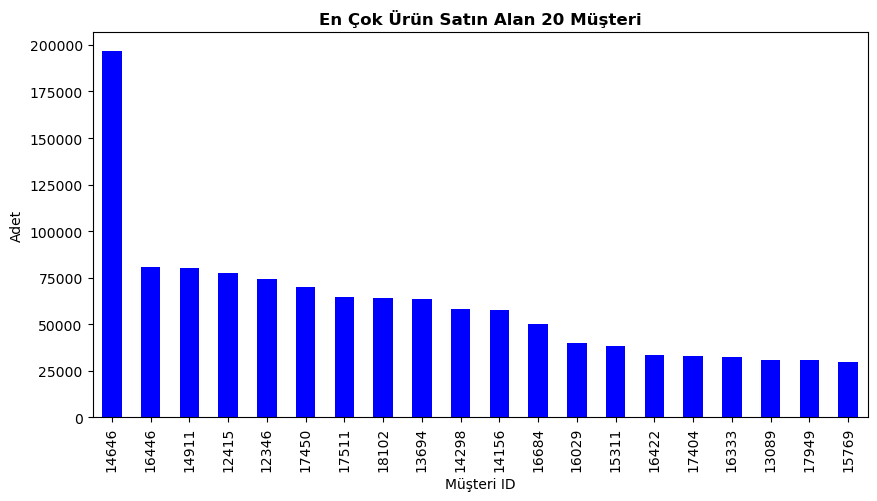

In [41]:
# En çok alışveriş yapan 20 müşteri:
veri.groupby("Müşteri ID")["Adet"].sum().sort_values(ascending=False).head(20).plot(kind="bar",color="b",figsize=(10,5))
plt.xlabel('Müşteri ID')
plt.ylabel('Adet')
plt.title('En Çok Ürün Satın Alan 20 Müşteri', fontweight='bold')
plt.show()

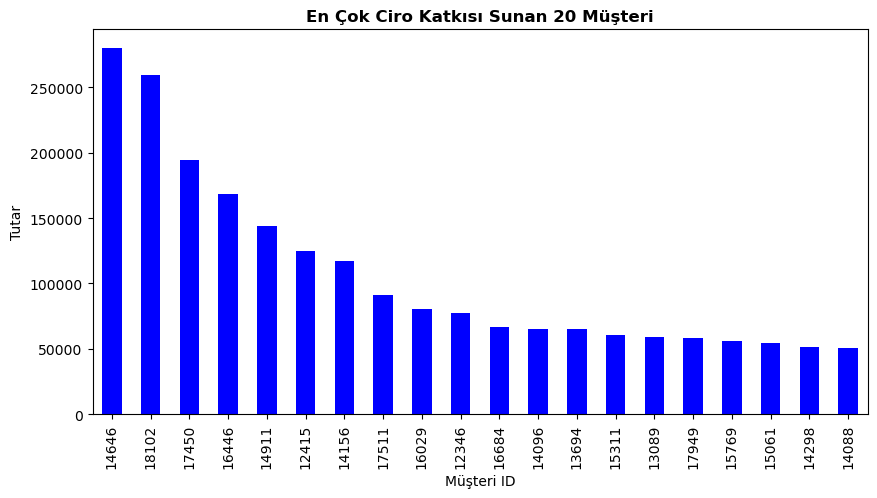

In [42]:
# En çok alışveriş yapan 20 müşteri:
veri.groupby("Müşteri ID")["Toplam Tutar"].sum().sort_values(ascending=False).head(20).plot(kind="bar",color="b",figsize=(10,5))
plt.xlabel('Müşteri ID')
plt.ylabel('Tutar')
plt.title('En Çok Ciro Katkısı Sunan 20 Müşteri', fontweight='bold')
plt.show()

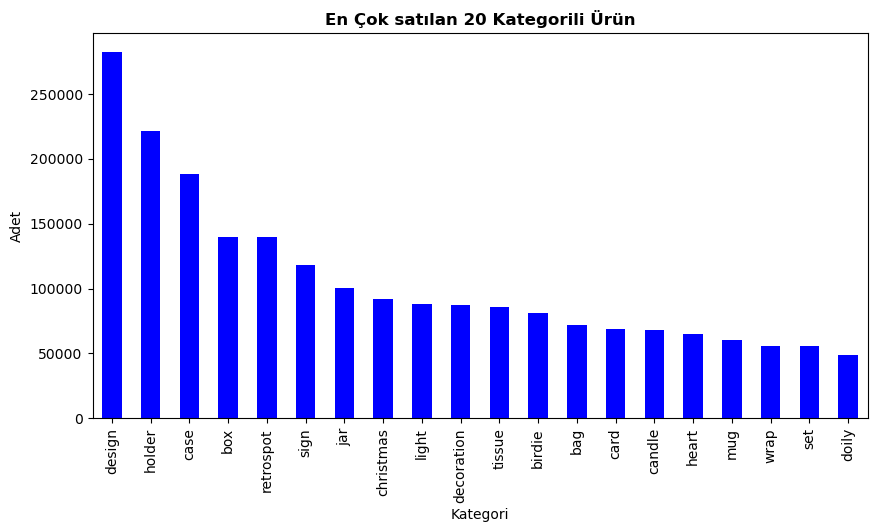

In [56]:
veri.groupby("Kategori")["Adet"].sum().sort_values(ascending=False).head(20).plot(kind="bar",color="b",figsize=(10,5))
plt.xlabel('Kategori')
plt.ylabel('Adet')
plt.title('En Çok satılan 20 Kategorili Ürün', fontweight='bold')
plt.show()

In [45]:
veri.groupby("Yıl")["Toplam Tutar"].mean()

Yıl
2010    22.221376
2011    22.660172
Name: Toplam Tutar, dtype: float64

In [46]:
veri.groupby("Yıl")["Toplam Tutar"].sum()

Yıl
2010     570422.730
2011    8316804.164
Name: Toplam Tutar, dtype: float64

In [47]:
veri.groupby("Yıl")["Adet"].sum()

Yıl
2010     311048
2011    4840955
Name: Adet, dtype: int64

In [54]:
veri.groupby(["Mevsim","Kategori"])["Adet"].sum()

Mevsim    Kategori
Kış       ahoy           14
          airmail       145
          album           6
          alphabet      822
          amber           1
                      ...  
İlkbahar  wool          169
          word         1441
          wrap        12837
          wreath        118
          zinc          730
Name: Adet, Length: 2460, dtype: int64

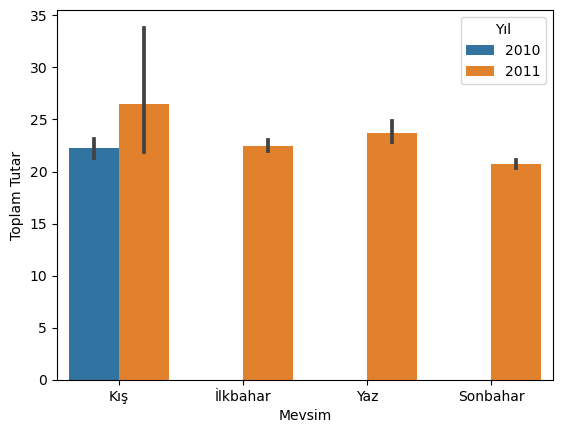

In [55]:
# Mevsimlere ve yıllara göre satışlar:
sns.barplot(x="Mevsim",y="Toplam Tutar",hue="Yıl",data=veri);

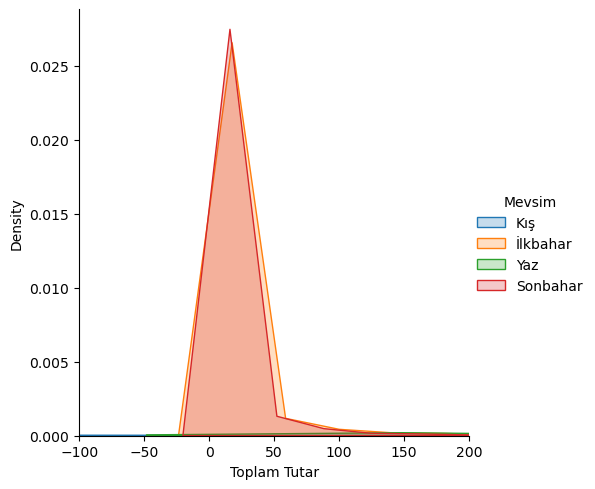

In [59]:
(sns
 .FacetGrid(veri,
         hue="Mevsim",
         height=5,
         xlim=(-100,200))
 .map(sns.kdeplot,"Toplam Tutar",shade=True)
 .add_legend()
);

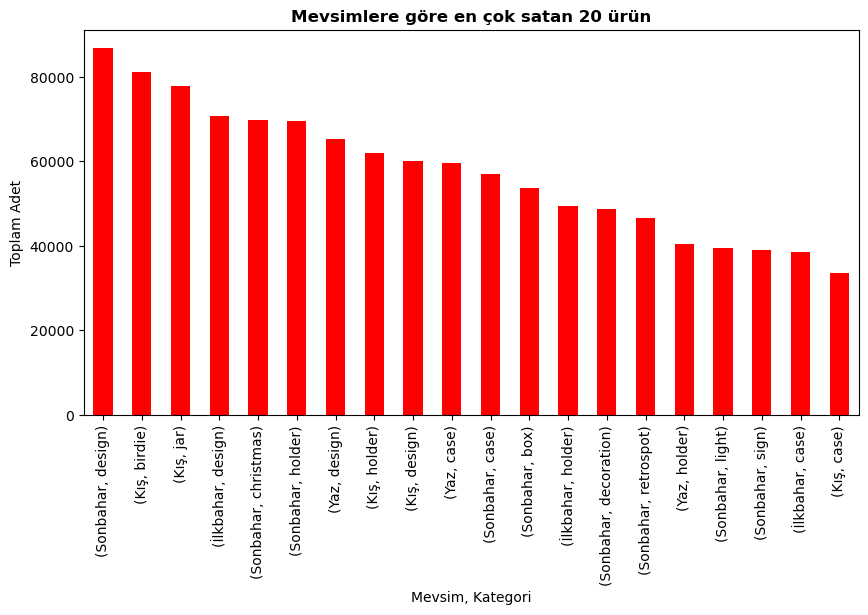

In [63]:
veri.groupby(["Mevsim","Kategori"])["Adet"].sum().sort_values(ascending=False).head(20).plot(kind="bar",color="r",figsize=(10,5))
plt.xlabel('Mevsim, Kategori')
plt.ylabel('Toplam Adet')
plt.title('Mevsimlere göre en çok satan 20 ürün', fontweight='bold')
plt.show()

In [68]:
veri.describe().T

,count,mean,std,min,25%,50%,75%,max
Adet,392693.0,13.119671,180.492603,1.000,2.00,6.00,12.00,80995.00
Birim Fiyat,392693.0,3.125952,22.241820,0.001,1.25,1.95,3.75,8142.75
Müşteri ID,392693.0,15287.837224,1713.542421,12346.000,13955.00,15150.00,16791.00,18287.00
Toplam Tutar,392693.0,22.631488,311.098828,0.001,4.95,12.45,19.80,168469.60


In [69]:
veri[veri["Adet"]==veri["Adet"].max()]

,Fatura No,Stok Kodu,Ürün Adı,Adet,Fatura Tarihi,Birim Fiyat,Müşteri ID,Ülke,Toplam Tutar,Ürün Adı2,Kategori,Gün,Hafta,Ay,Yıl,Mevsim
392226,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,168469.6,paper craft little birdie,birdie,9,49,12,2011,Kış


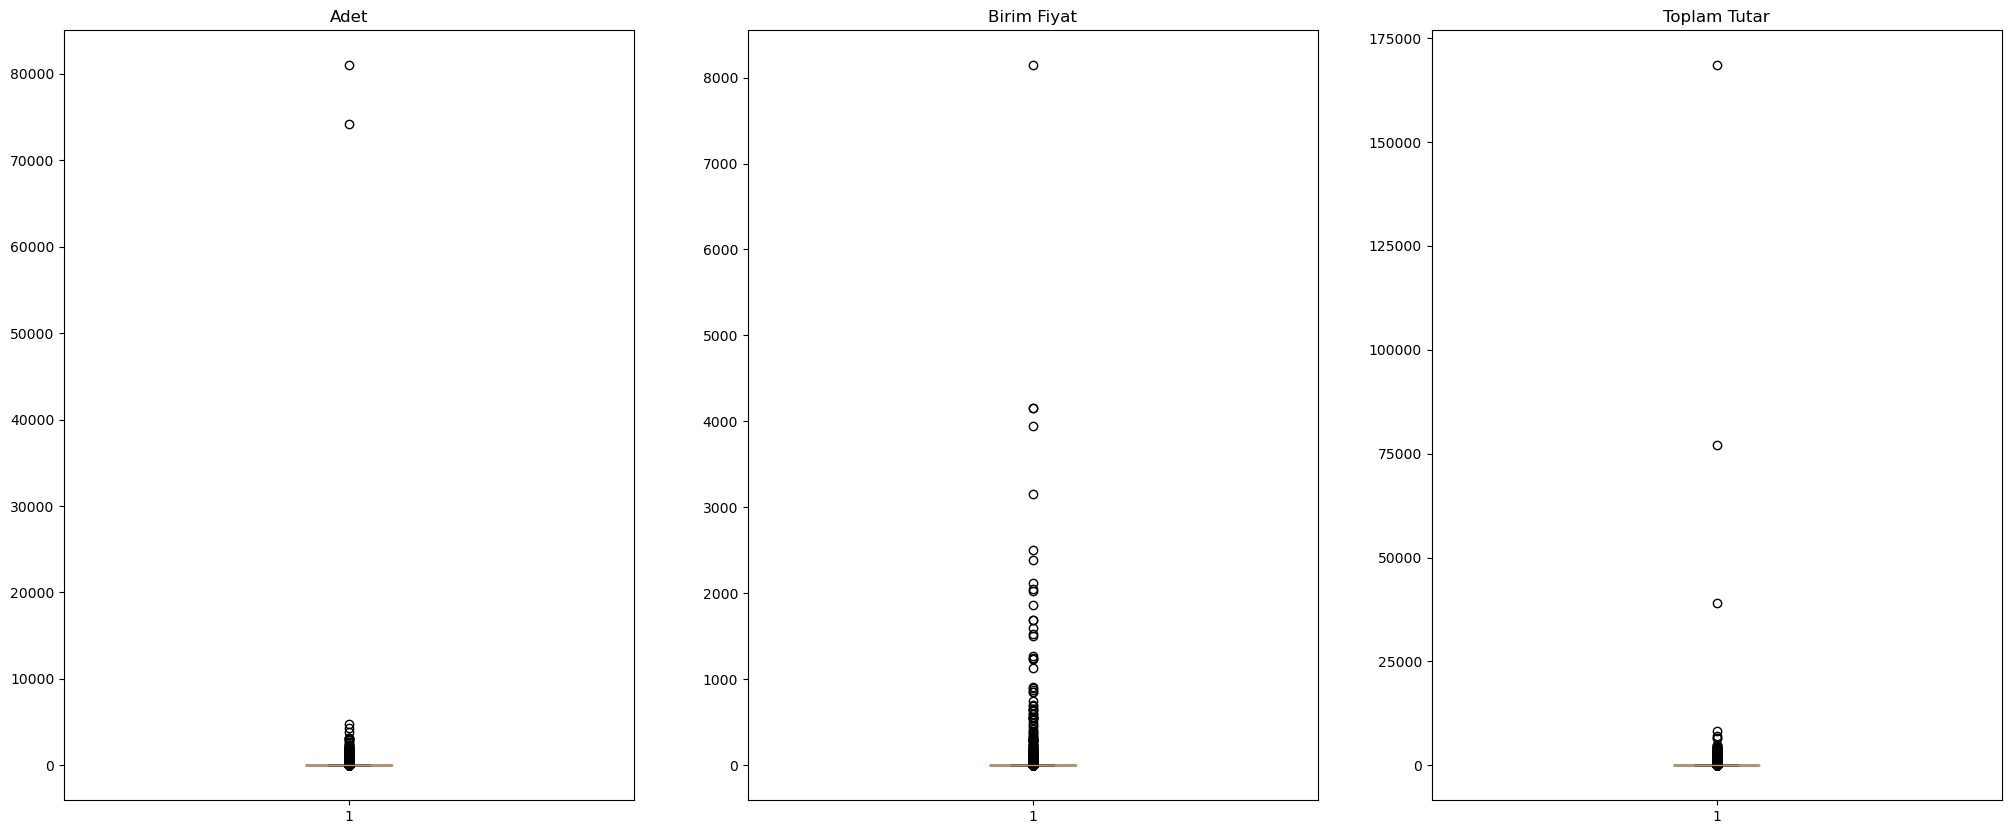

In [70]:
fig,ax=plt.subplots(1,3,figsize=(25,10))
ax[0].boxplot(veri["Adet"])
ax[0].set_title("Adet")
ax[1].boxplot(veri["Birim Fiyat"])
ax[1].set_title("Birim Fiyat")
ax[2].boxplot(veri["Toplam Tutar"])
ax[2].set_title("Toplam Tutar")
plt.show()

In [76]:
veri["Adet"].sort_values(ascending=False)

392226    80995
36521     74215
304654     4800
141558     4300
60687      3906
          ...  
290975        1
290974        1
290973        1
290972        1
392692        1
Name: Adet, Length: 392693, dtype: int64

In [77]:
veri=veri.drop(index=[392226,36521])

# RFM

In [87]:
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [80]:
# Toplam aykırı gözlem değerlerini silelim:
Q1=veri["Toplam Tutar"].quantile(0.25)
Q3=veri["Toplam Tutar"].quantile(0.75)
IQR=Q3-Q1

altsinir=Q1-1.5*IQR
ustsinir=Q3+1.5*IQR

veri=veri[~((veri["Toplam Tutar"]>ustsinir) | (veri["Toplam Tutar"]<altsinir))]

veri=veri.reset_index(drop=True)

In [82]:
## Kaç müşteri var?
print(len(veri["Müşteri ID"].unique()))
print(veri["Müşteri ID"].nunique())

4194
4194


In [83]:
## Eşsiz Fatura adeti:
print(veri["Fatura No"].nunique())

16806


In [85]:
## Statik veriseti ile calıstıgımız icin bugunun tarihi olarak veri setinde ki max tarihi ele alacağız.
bugun=veri["Fatura Tarihi"].max()
bugun

Timestamp('2011-12-09 12:50:00')

In [88]:
bugun=dt.datetime(2011,12,9,12,50,0)

In [89]:
# recency:
# Bugunun tarihi ile gruplamış olduğumuz müşteri id'nin fatura tarihindeki max değeri tespit edip bunun içerisindeki günü alalım:
r=(bugun-veri.groupby("Müşteri ID").agg({"Fatura Tarihi":"max"})).apply(lambda x:x.dt.days)

In [90]:
# frequency:
# Bir müşterinin tekrarsız olarak kaç tane faturaya sahip olduğunu bulalım:
f = veri.groupby(["Müşteri ID","Fatura No"]).agg({"Fatura No":"count"})
f=f.groupby("Müşteri ID").agg({"Fatura No":"count"})

In [91]:
# monetary:
# her bir müşteri firmaya ne kadar para kazandırdığı:
m=veri.groupby("Müşteri ID").agg({"Toplam Tutar":"sum"})

In [92]:
RFM=r.merge(f,on="Müşteri ID").merge(m,on="Müşteri ID")
RFM=RFM.reset_index()
RFM=RFM.rename(columns={"Müşteri ID":"Müşteri","Fatura Tarihi":"Recency","Fatura No":"Frequency","Toplam Tutar":"Monetary"})
RFM

,Müşteri,Recency,Frequency,Monetary
0,12347,1,7,3174.62
1,12348,74,4,601.64
2,12349,18,1,1145.35
3,12350,309,1,334.40
4,12352,35,7,1505.74
...,...,...,...,...
4189,18280,277,1,180.60
4190,18281,180,1,80.82
4191,18282,7,2,178.05
4192,18283,3,16,2045.53


## Kümeleme:

In [93]:
df=RFM.iloc[:,1:]
df

,Recency,Frequency,Monetary
0,1,7,3174.62
1,74,4,601.64
2,18,1,1145.35
3,309,1,334.40
4,35,7,1505.74
...,...,...,...
4189,277,1,180.60
4190,180,1,80.82
4191,7,2,178.05
4192,3,16,2045.53


In [95]:
# Normalizasyon:
ms=MinMaxScaler()
dfnorm=ms.fit_transform(df)
dfnorm=pd.DataFrame(dfnorm,columns=df.columns)

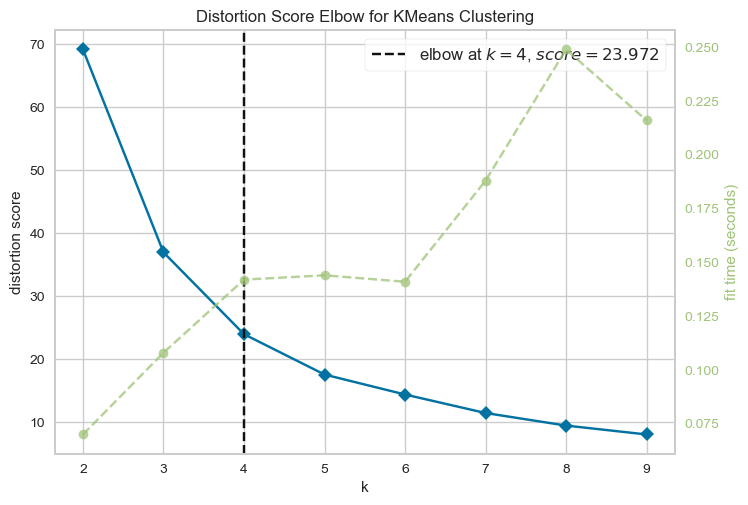

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [96]:
# Kmeans:
kmodel=KMeans(random_state=0)
grafik=KElbowVisualizer(kmodel,k=(2,10)) # optimal k değerinin bulunması için uygulanır.
grafik.fit(dfnorm)
grafik.poof()

In [97]:
kmodel=KMeans(random_state=0,n_clusters=4,init="k-means++")
kfit=kmodel.fit(dfnorm)
labels=kfit.labels_

In [98]:
RFM["Labels"]=labels

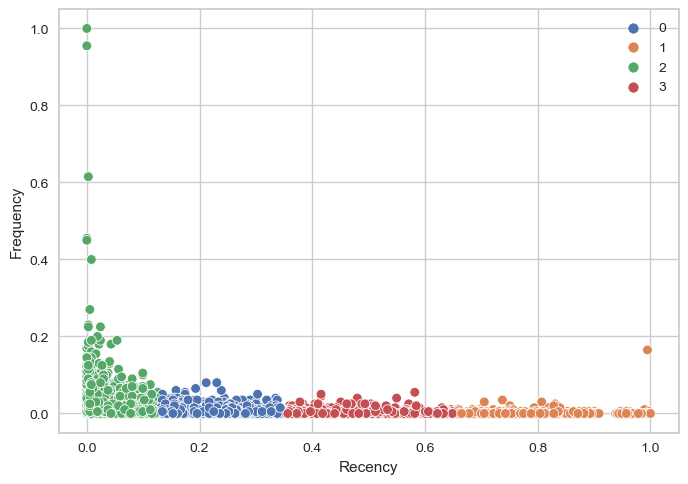

In [99]:
sns.scatterplot(x="Recency",y="Frequency",data=dfnorm,hue=labels,palette="deep")
plt.show()

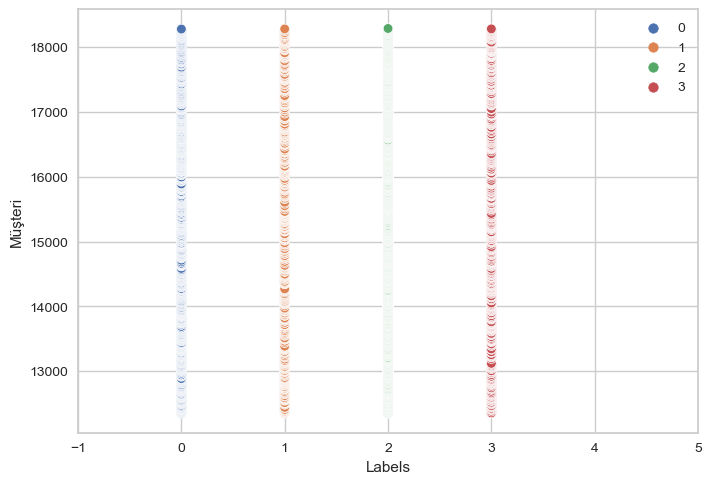

In [100]:
sns.scatterplot(x="Labels",y="Müşteri",data=RFM,hue=labels,palette="deep")
plt.xlim([-1,5])
plt.show()

In [102]:
print(RFM.groupby("Labels")["Müşteri"].count())

Labels
0    1037
1     506
2    2038
3     613
Name: Müşteri, dtype: int64


In [103]:
print(RFM.groupby("Labels").mean().iloc[:,1:])

           Recency  Frequency     Monetary
Labels                                    
0        77.222758   2.600771   706.376424
1       304.104743   1.328063   275.895336
2        18.124632   6.031894  1590.804888
3       184.539967   1.866232   423.224716


* 1. Grup'un Recency değeri yüksek. Bu grup firmadan uzun zamandır alışveriş yapmıyor. Bu gruba dahil olan müşteriler ortalama 1.3 kez alış veriş yapmış ve bu alış verişleri için ortalama 275 dolar ödeme yapmışlar.
* 3. Grup kaybedilmemesi gereken müşteri grubudur. Recency değeri en düşük, alış veriş yapma sıklıkları en yüksek ve alış veriş başına ortalama en çok ödemeyi yapan gruptur.